In [2]:
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from keras.initializers import Constant
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import seaborn as sns
import pandas as pd
from tensorflow.keras.applications import ResNet152V2
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from matplotlib import image
from keras.applications.densenet import DenseNet121

In [3]:
# train, validation, test directories
train_directory = '/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/train/'
val_directory = '/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/val/'
test_directory = '/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/test/'

In [4]:
import os
os.path.exists(train_directory)
os.path.exists(val_directory)
os.path.exists(test_directory)

True

,number_of_images,disease
0,1341,normal
1,3874,pneumonia


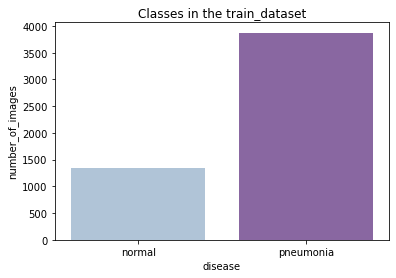

In [5]:
# function calculating number of files in each category : test - normal and pneumonia, train - normal and pneumonia 
def files_calc(path):
    return (len([name for name in os.listdir(path)]))

train_normal_files = files_calc('/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/train/NORMAL')
train_pneumonia_files = files_calc('/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/train/PNEUMONIA')
test_normal_files = files_calc('/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/test/NORMAL')
test_pneumonia_files = files_calc('/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/test//PNEUMONIA')

# dataframe comparing number of train files
train_barplot = pd.DataFrame({'number_of_images':[train_normal_files,train_pneumonia_files], 'disease':['normal', 'pneumonia']})
display(train_barplot)
sns.barplot(y = 'number_of_images', x = 'disease', 
            data = train_barplot,
            palette=("BuPu")).set_title('Classes in the train_dataset');


,number_of_images,disease
0,234,normal
1,390,pneumonia


array([1.06087196])

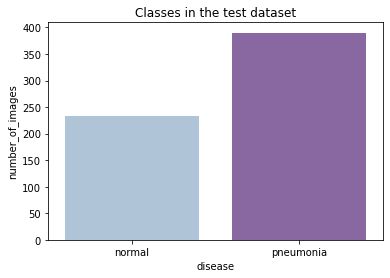

In [6]:
# dataframe comparing number of test files
test_barplot = pd.DataFrame({'number_of_images':[test_normal_files,test_pneumonia_files], 'disease':['normal', 'pneumonia']})
display(test_barplot)

sns.barplot(y = 'number_of_images', x = 'disease', 
            data = test_barplot,
            palette=("BuPu")).set_title('Classes in the test dataset');



# because of imbalanced classes according to tensorflow: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#optional_set_the_correct_initial_bias
# I decided to add initial bias od output layer

initial_bias = np.log([train_pneumonia_files/train_normal_files])
initial_bias

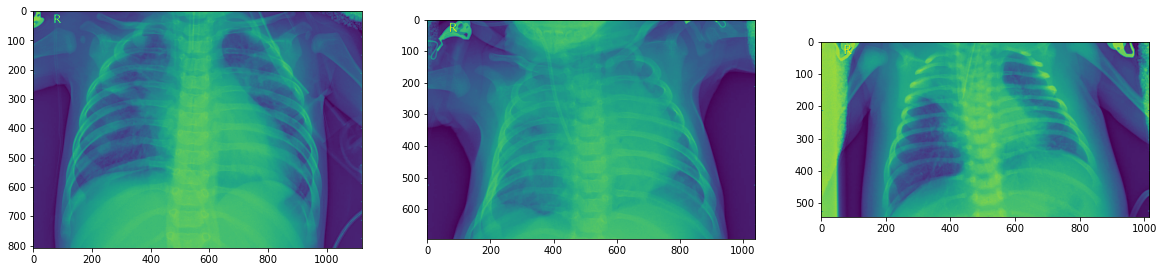

In [7]:
#iterating images in test pneumonia files to show random pictures  
images = [name for name in os.listdir('/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/test//PNEUMONIA')]
plt.figure(figsize=(20,10))
img_dir = '/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/test/PNEUMONIA'
for i in range(3):
    plt.subplot(1,3,i+1)
    img = plt.imread(os.path.join(img_dir,images[i]))
    plt.imshow(img)  
                     


In [8]:
train_generator = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization= True, 
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1/255,
    validation_split = 0.05,
    horizontal_flip=True,
    zoom_range=0.1) 

test_generator = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization= True, 
    rescale=1/255)

In [9]:
batchSize=32
h = 160
w = 160
#Load images
train_flow = train_generator.flow_from_directory(
    directory=r'/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/train',
    target_size=(h, w),
    color_mode="rgb",
    batch_size=batchSize,
    class_mode="binary",
    shuffle=True,
    subset = "training",
    seed=10
)

valid_flow = train_generator.flow_from_directory(
    directory=r'/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/train/',
    target_size=(h, w),
    color_mode="rgb",
    batch_size=batchSize,
    class_mode="binary",
    shuffle=True,
    subset = "validation",
    seed=10
    
)

test_flow = test_generator.flow_from_directory(
    directory=r"/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2//test/",
    target_size=(h, w),
    color_mode="rgb",
    batch_size=batchSize,
    class_mode='binary',
    shuffle=True,
    seed=10
    
)




Found 4946 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [10]:
# according to https://www.kaggle.com/code/kmkarakaya/transfer-learning-for-image-classification/notebook
stepsPerEpoch= (train_flow.samples+ (batchSize-1)) // batchSize
print("stepsPerEpoch: ", stepsPerEpoch)

validationSteps=(valid_flow.samples+ (batchSize-1)) // batchSize
print("validationSteps: ", validationSteps)


stepsPerEpoch:  155
validationSteps:  9


In [11]:
# sieć z dwiema warstwami 

In [11]:
def build_model(input_shape):
    
    model = Sequential()
    model.add(Conv2D(8, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.3))
    #model.add(Conv2D(8, 3, activation="relu", input_shape=input_shape))
    #model.add(MaxPool2D((2,2)))
    #model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(8, "relu"))
    model.add(Dense(1, "sigmoid",bias_initializer=tf.keras.initializers.Constant(initial_bias)))
    
    return model






In [12]:
model = build_model((h, w, 3))

model.compile(loss="binary_crossentropy", 
              optimizer='Adam', 
              metrics=["accuracy"])



2022-05-05 20:32:22.666897: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True)

history = model.fit(train_flow, 
          validation_data=valid_flow,
          steps_per_epoch=stepsPerEpoch,      
          validation_steps=validationSteps, 
          callbacks = early_stopping_cb,
          epochs = 50)

Epoch 1/50
155/155 [==============================] - 137s 883ms/step - loss: 0.1747 - accuracy: 0.9325 - val_loss: 0.1985 - val_accuracy: 0.9266
Epoch 2/50
155/155 [==============================] - 128s 826ms/step - loss: 0.1571 - accuracy: 0.9454 - val_loss: 0.1974 - val_accuracy: 0.9151
Epoch 3/50
155/155 [==============================] - 127s 817ms/step - loss: 0.1668 - accuracy: 0.9337 - val_loss: 0.2209 - val_accuracy: 0.9189
Epoch 4/50
155/155 [==============================] - 125s 806ms/step - loss: 0.1623 - accuracy: 0.9397 - val_loss: 0.1461 - val_accuracy: 0.9421
Epoch 5/50
155/155 [==============================] - 124s 801ms/step - loss: 0.1546 - accuracy: 0.9395 - val_loss: 0.1721 - val_accuracy: 0.9266
Epoch 6/50
155/155 [==============================] - 124s 801ms/step - loss: 0.1517 - accuracy: 0.9436 - val_loss: 0.1795 - val_accuracy: 0.9151
Epoch 7/50
155/155 [==============================] - 125s 806ms/step - loss: 0.1389 - accuracy: 0.9446 - val_loss: 0.1807 -

In [15]:

model.predict(test_flow)

array([[4.70154971e-01],
       [9.99959767e-01],
       [9.99972761e-01],
       [9.99880254e-01],
       [2.67597735e-02],
       [7.00657964e-02],
       [9.99992609e-01],
       [9.67735767e-01],
       [9.99947429e-01],
       [2.88694054e-01],
       [2.09117711e-01],
       [9.99997616e-01],
       [2.51465142e-02],
       [9.99982774e-01],
       [9.99968946e-01],
       [9.97411489e-01],
       [9.86871481e-01],
       [9.53074396e-02],
       [9.43767965e-01],
       [3.99039388e-02],
       [9.99167740e-01],
       [7.79091179e-01],
       [9.99945104e-01],
       [9.99204755e-01],
       [1.53326362e-01],
       [9.99998748e-01],
       [9.99966145e-01],
       [9.99999821e-01],
       [6.93535030e-01],
       [9.99618173e-01],
       [9.99999285e-01],
       [9.99987960e-01],
       [5.09453416e-02],
       [9.99995053e-01],
       [9.43875968e-01],
       [9.98864591e-01],
       [9.49635088e-01],
       [9.92210746e-01],
       [9.99967098e-01],
       [9.92024541e-01],


In [16]:
accuracy_score(test_flow.labels, 
               np.squeeze(model.predict(test_flow)>0.5))

0.5368589743589743

In [17]:
def treshold(pred):
    if pred <= 0.5:
        return 0
    else:
        return 1

In [18]:
def assess_model(model):
    predicted_vals = model.predict(test_flow, steps = len(test_flow))
    vfunc = np.vectorize(treshold)
    predictions = vfunc(predicted_vals)
    accuracy = accuracy_score(test_flow.classes, predictions)
    print('Accuracy: %f' % accuracy)
    print()
    f1 = f1_score(test_flow.classes, predictions)
    print('F1 score: %f' % f1)
    print()
    precision = precision_score(test_flow.classes, predictions)
    print('Precision_score : %f' % precision)
    print()
    recall = recall_score(test_flow.classes, predictions)
    print('Recall_score: %f' % recall)
    print()
    print('Confusion matrix')
    cm = confusion_matrix(y_true=test_flow.classes, y_pred=predictions)
    print(cm)

In [19]:
assess_model(model)

Accuracy: 0.524038

F1 score: 0.653442

Precision_score : 0.599572

Recall_score: 0.717949

Confusion matrix
[[ 47 187]
 [110 280]]


In [20]:
history_dict = history.history

In [21]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)


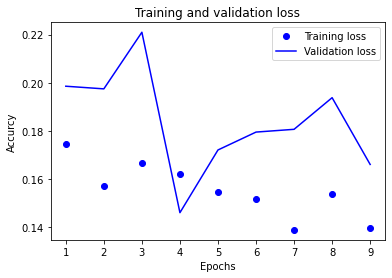

In [23]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accurcy')
plt.legend()
plt.show()

In [24]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

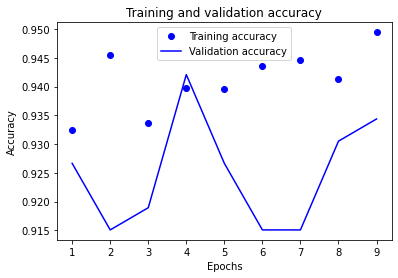

In [25]:
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
def build_model(input_shape):
    
    model = Sequential()
    model.add(Conv2D(32, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(16, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(16, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(8, "relu"))
    model.add(Dense(1, "sigmoid"))
    
    return model






In [27]:
model = build_model((h, w, 3))

model.compile(loss="binary_crossentropy", 
              optimizer='Adam', 
              metrics=["accuracy"])



In [28]:
early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True)

history = model.fit(train_flow, 
          validation_data=valid_flow,
          steps_per_epoch=stepsPerEpoch,      
          validation_steps=validationSteps, 
          callbacks = early_stopping_cb,
          epochs = 50)

Epoch 1/50
155/155 [==============================] - 174s 1s/step - loss: 0.5014 - accuracy: 0.7430 - val_loss: 0.5093 - val_accuracy: 0.7452
Epoch 2/50
155/155 [==============================] - 166s 1s/step - loss: 0.3725 - accuracy: 0.8391 - val_loss: 0.4753 - val_accuracy: 0.8378
Epoch 3/50
155/155 [==============================] - 166s 1s/step - loss: 0.3536 - accuracy: 0.8619 - val_loss: 0.4251 - val_accuracy: 0.8842
Epoch 4/50
155/155 [==============================] - 166s 1s/step - loss: 0.3272 - accuracy: 0.8797 - val_loss: 0.4383 - val_accuracy: 0.8919
Epoch 5/50
155/155 [==============================] - 165s 1s/step - loss: 0.2966 - accuracy: 0.8959 - val_loss: 0.4046 - val_accuracy: 0.8726
Epoch 6/50
155/155 [==============================] - 168s 1s/step - loss: 0.2814 - accuracy: 0.9038 - val_loss: 0.4460 - val_accuracy: 0.7876
Epoch 7/50
155/155 [==============================] - 173s 1s/step - loss: 0.2619 - accuracy: 0.9100 - val_loss: 0.2965 - val_accuracy: 0.9112

In [29]:
model.predict(test_flow)

array([[0.52122897],
       [0.375727  ],
       [0.9332745 ],
       [0.35033303],
       [0.9947329 ],
       [0.9703429 ],
       [0.35033303],
       [0.9816679 ],
       [0.99820435],
       [0.35033303],
       [0.9856551 ],
       [0.35033303],
       [0.47706136],
       [0.961565  ],
       [0.5466812 ],
       [0.99209917],
       [0.8610165 ],
       [0.9992091 ],
       [0.6205895 ],
       [0.51009804],
       [0.76847184],
       [0.37896258],
       [0.9828979 ],
       [0.8462821 ],
       [0.9511979 ],
       [0.8991065 ],
       [0.99780655],
       [0.8485444 ],
       [0.35033303],
       [0.666051  ],
       [0.35033303],
       [0.35033303],
       [0.9372144 ],
       [0.998597  ],
       [0.35033303],
       [0.58674276],
       [0.98832977],
       [0.45590267],
       [0.98482215],
       [0.35033303],
       [0.35033303],
       [0.9942907 ],
       [0.99787545],
       [0.9737065 ],
       [0.35033303],
       [0.35033303],
       [0.35033303],
       [0.994

In [30]:
accuracy_score(test_flow.labels, 
               np.squeeze(model.predict(test_flow)>0.5))

0.5625

In [31]:
def treshold(pred):
    if pred <= 0.5:
        return 0
    else:
        return 1

In [ ]:
def assess_model(model):
    predicted_vals = model.predict(test_flow, steps = len(test_flow))
    vfunc = np.vectorize(treshold)
    predictions = vfunc(predicted_vals)
    accuracy = accuracy_score(test_flow.classes, predictions)
    print('Accuracy: %f' % accuracy)
    print()
    f1 = f1_score(test_flow.classes, predictions)
    print('F1 score: %f' % f1)
    print()
    precision = precision_score(test_flow.classes, predictions)
    print('Precision_score : %f' % precision)
    print()
    recall = recall_score(test_flow.classes, predictions)
    print('Recall_score: %f' % recall)
    print()
    print('Confusion matrix')
    cm = confusion_matrix(y_true=test_flow.classes, y_pred=predictions)
    print(cm)

In [33]:
assess_model(model)

Accuracy: 0.536859

F1 score: 0.635561

Precision_score : 0.625310

Recall_score: 0.646154

Confusion matrix
[[ 83 151]
 [138 252]]


In [34]:
history_dict = history.history

In [35]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)


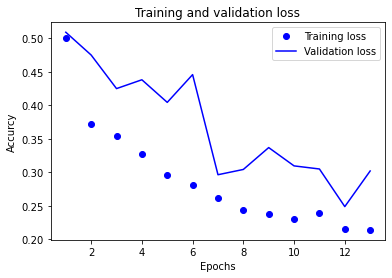

In [37]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accurcy')
plt.legend()
plt.show()

In [38]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

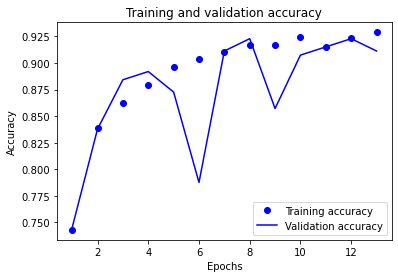

In [39]:
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
def build_model(input_shape):
    
    model = Sequential()
    model.add(Conv2D(8, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(8, "relu"))
    model.add(Dense(1, "sigmoid"))
    
    return model






In [41]:
model = build_model((h, w, 3))

model.compile(loss="binary_crossentropy", 
              optimizer='Adam', 
              metrics=["accuracy"])



In [42]:
model.predict(test_flow)

array([[0.33720958],
       [0.32812816],
       [0.20243496],
       [0.40430084],
       [0.2185776 ],
       [0.39107832],
       [0.27502993],
       [0.30859536],
       [0.22911155],
       [0.25573575],
       [0.3611315 ],
       [0.40216428],
       [0.36078525],
       [0.27247477],
       [0.28688267],
       [0.46841693],
       [0.43460315],
       [0.3867393 ],
       [0.32685754],
       [0.3482558 ],
       [0.20832476],
       [0.2464684 ],
       [0.36643666],
       [0.30747068],
       [0.35034794],
       [0.23783842],
       [0.35314888],
       [0.29239893],
       [0.36558658],
       [0.25385416],
       [0.33362645],
       [0.3671959 ],
       [0.31183374],
       [0.44854015],
       [0.25634417],
       [0.36500442],
       [0.36546636],
       [0.23114604],
       [0.21411747],
       [0.30958912],
       [0.31849194],
       [0.23311928],
       [0.3923274 ],
       [0.30717528],
       [0.4201832 ],
       [0.30733448],
       [0.36602038],
       [0.342

In [43]:
accuracy_score(test_flow.labels, 
               np.squeeze(model.predict(test_flow)>0.5))

0.3766025641025641

In [44]:
def treshold(pred):
    if pred <= 0.5:
        return 0
    else:
        return 1

In [45]:
def assess_model(model):
    predicted_vals = model.predict(test_flow, steps = len(test_flow))
    vfunc = np.vectorize(treshold)
    predictions = vfunc(predicted_vals)
    accuracy = accuracy_score(test_flow.classes, predictions)
    print('Accuracy: %f' % accuracy)
    print()
    f1 = f1_score(test_flow.classes, predictions)
    print('F1 score: %f' % f1)
    print()
    precision = precision_score(test_flow.classes, predictions)
    print('Precision_score : %f' % precision)
    print()
    recall = recall_score(test_flow.classes, predictions)
    print('Recall_score: %f' % recall)
    print()
    print('Confusion matrix')
    cm = confusion_matrix(y_true=test_flow.classes, y_pred=predictions)
    print(cm)

In [46]:
assess_model(model)

Accuracy: 0.373397

F1 score: 0.034568

Precision_score : 0.466667

Recall_score: 0.017949

Confusion matrix
[[226   8]
 [383   7]]


In [47]:
history_dict = history.history

In [48]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)


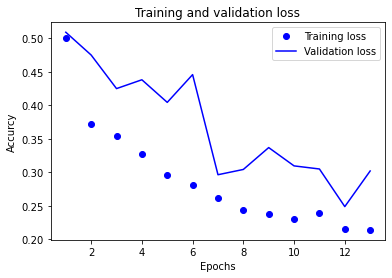

In [50]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accurcy')
plt.legend()
plt.show()

In [51]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

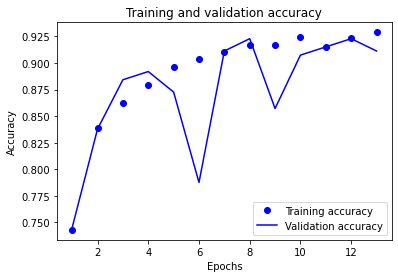

In [52]:
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [54]:
#dnesenet

In [12]:

base_model = DenseNet121(weights='imagenet', input_shape= (h, w, 3), include_top=False)

base_model.trainable = False

inputs = tf.keras.Input(shape= (h, w, 3))

x = base_model(inputs, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(1, activation = 'sigmoid', 
                             bias_initializer=tf.keras.initializers.Constant(initial_bias)
)(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=tf.keras.metrics.Accuracy())

2022-05-06 08:22:39.156324: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True)

history = model.fit(train_flow, 
          validation_data=valid_flow,
          steps_per_epoch=stepsPerEpoch,      
          validation_steps=validationSteps, 
          callbacks = early_stopping_cb,
          epochs = 50)

Epoch 1/50
155/155 [==============================] - 359s 2s/step - loss: 0.3387 - accuracy: 0.0000e+00 - val_loss: 0.2012 - val_accuracy: 0.0000e+00
Epoch 2/50
155/155 [==============================] - 343s 2s/step - loss: 0.1927 - accuracy: 0.0000e+00 - val_loss: 0.1559 - val_accuracy: 0.0000e+00
Epoch 3/50
155/155 [==============================] - 341s 2s/step - loss: 0.1565 - accuracy: 0.0000e+00 - val_loss: 0.1434 - val_accuracy: 0.0000e+00
Epoch 4/50
155/155 [==============================] - 339s 2s/step - loss: 0.1420 - accuracy: 0.0000e+00 - val_loss: 0.1365 - val_accuracy: 0.0000e+00
Epoch 5/50
155/155 [==============================] - 342s 2s/step - loss: 0.1286 - accuracy: 0.0000e+00 - val_loss: 0.1099 - val_accuracy: 0.0000e+00
Epoch 6/50
155/155 [==============================] - 341s 2s/step - loss: 0.1238 - accuracy: 0.0000e+00 - val_loss: 0.1209 - val_accuracy: 0.0000e+00


In [ ]:



assess_model(model)

In [ ]:
history_dict = history.history

In [ ]:
history_dict.keys()

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)


In [ ]:
plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

In [ ]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

In [ ]:
?plt.xlim

In [ ]:
plt.plot(epochs, acc, 'bo', label='Dokładność trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokładność walidacji')
plt.ylim(0.6,0.8)
plt.title('Dokładność trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

In [ ]:
#ResNet152V2

In [ ]:

base_model = ResNet152V2(weights='imagenet', input_shape= (h, w, 3), include_top=False)


base_model.trainable = False

inputs = tensorflow.keras.Input(shape= (h, w, 3))

x = base_model(inputs, training=False)

x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)

outputs = tensorflow.keras.layers.Dense(1, activation = 'sigmoid', 
                             bias_initializer=tensorflow.keras.initializers.Constant(initial_bias)
)(x)
model = tensorflow.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss=tensorflow.keras.losses.BinaryCrossentropy(), metrics=tensorflow.keras.metrics.Accuracy())

In [ ]:
early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True)

history = model.fit(train_flow, 
          validation_data=valid_flow,
          steps_per_epoch=stepsPerEpoch,      
          validation_steps=validationSteps, 
          callbacks = early_stopping_cb,
          epochs = 50)

In [ ]:
assess_model(model)

In [ ]:
history_dict = history.history

In [ ]:
history_dict.keys()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
acc = history.history['raccuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)


In [ ]:
plt.plot(epochs, loss, '--', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

In [ ]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

In [ ]:
?plt.xlim

In [ ]:
plt.plot(epochs, acc_values, '--', label='Dokładność trenowania')
plt.plot(epochs, val_acc_values, 'b', label='Dokładność walidacji')
plt.ylim(0.6,0.8)
plt.title('Dokładność trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

In [ ]:
# to co wyzej tylko dwie wartwy

In [ ]:
def build_model(input_shape):
    
    model = Sequential()
    model.add(Conv2D(16, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(8, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(8, "relu"))
    model.add(Dense(1, "sigmoid"))
    
    return model

In [ ]:
model = build_model((h, w, 3))
opt =  tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="binary_crossentropy", 
              optimizer=opt, 
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss", 
                               patience=5,
                               restore_best_weights=True)

In [ ]:
model.fit(train_flow,
          validation_data=valid_flow,
          callbacks=[early_stopping],
          epochs=100)

In [ ]:
import numpy as np
model.predict(test_flow)

In [ ]:
accuracy_score(test_flow.labels, 
               np.squeeze(model.predict(test_flow)>0.5))

In [ ]:
# validation split 

In [ ]:
def build_model(input_shape):
    
    model = Sequential()
    model.add(Conv2D(32, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(8, "relu"))
    model.add(Dense(1, "sigmoid"))
    
    return model

In [ ]:
model = build_model((h, w, 3))

model.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss", 
                               patience=5,
                               restore_best_weights=True)

In [ ]:
model.fit(train_flow,
          validation_data=valid_flow,
          callbacks=[early_stopping],
          epochs=100)

In [ ]:
model.predict(test_flow)

In [ ]:
accuracy_score(test_flow.labels, 
               np.squeeze(model.predict(test_flow)>0.5))

In [ ]:
# SGD learning rate 0.0001

In [ ]:
model = build_model((h, w, 3))
opt = keras.optimizers.SGD(learning_rate=0.0001)
model.compile(loss="binary_crossentropy", 
              optimizer=opt, 
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_accuracy", 
                               patience=10,
                               restore_best_weights=False)

In [ ]:
model.fit(train_flow,
          validation_data=valid_flow,
          callbacks=[early_stopping],
          epochs=5)

In [ ]:
import numpy as np
model.predict(test_flow)

In [ ]:
accuracy_score(test_flow.labels, 
               np.squeeze(model.predict(test_flow)>0.5))

In [ ]:
# adam, imbalance problem
def build_model(input_shape):
    
    model = Sequential()
    model.add(Conv2D(128, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.01))
    model.add(Flatten())
    model.add(Dense(8, "relu"))
    model.add(Dense(1, "sigmoid", bias_initializer=keras.initializers.Constant(initial_bias))
    
    return model
model = build_model((h, w, 3))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="binary_crossentropy", 
              optimizer=opt, 
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_accuracy", 
                               patience=10,
                               restore_best_weights=False)

model.fit(train_flow,
          validation_data=valid_flow,
          callbacks=[early_stopping],
          epochs=100)

import numpy as np
model.predict(test_flow)

accuracy_score(test_flow.labels, 
               np.squeeze(model.predict(test_flow)>0.5))



In [ ]:
# to samo co wyżej z ucaugmentacją danych

In [ ]:
h, w = 160, 160
#input_shape = X.train.shape[1:]
train_generator = ImageDataGenerator(rescale=1/255,
                                     rotation_range=45,
                                     zoom_range=0.1,
                                     # brightness_range=(-0.1, 0.1),
                                     horizontal_flip=True)
valid_generator = ImageDataGenerator(rescale=1/255)

train_flow = train_generator.flow_from_directory(train_directory,
                                                 target_size=(h, w),
                                                 batch_size=32,
                                                 class_mode="binary")
valid_flow = train_generator.flow_from_directory(val_directory,
                                                 target_size=(h, w),
                                                 batch_size=32,
                                                 class_mode="binary")
test_flow = train_generator.flow_from_directory(test_directory,
                                                 target_size=(h, w),
                                                 batch_size=32,
                                                 class_mode="binary")

In [ ]:
def build_model(input_shape):
    
    model = Sequential()
    model.add(Conv2D(128, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.01))
    model.add(Flatten())
    model.add(Dense(8, "relu"))
    model.add(Dense(1, "sigmoid"))
    
    return model

model = build_model((h, w, 3))

model.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_accuracy", 
                               patience=10,
                               restore_best_weights=False)

#model.fit(train_flow, valid_flow, epochs=10) # uczenie wstępne 10 epok
model.fit(train_flow,
          validation_data=valid_flow,
          callbacks=[early_stopping],
          epochs=5)

import numpy as np
model.predict(test_flow)

accuracy_score(test_flow.labels, 
               np.squeeze(model.predict(test_flow)>0.5))

In [ ]:
h, w = 160, 160
#input_shape = X.train.shape[1:]
train_generator = ImageDataGenerator(rescale=1/255)
valid_generator = ImageDataGenerator(rescale=1/255)

train_flow = train_generator.flow_from_directory(train_directory,
                                                 target_size=(h, w),
                                                 batch_size=32,
                                                 class_mode="binary")
valid_flow = train_generator.flow_from_directory(val_directory,
                                                 target_size=(h, w),
                                                 batch_size=32,
                                                 class_mode="binary")
test_flow = train_generator.flow_from_directory(test_directory,
                                                 target_size=(h, w),
                                                 batch_size=32,
                                                 class_mode="binary")

In [ ]:
#zwiększenie dropoutu

In [ ]:
def build_model(input_shape):
    
    model = Sequential()
    model.add(Conv2D(16, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(8, "relu"))
    model.add(Dense(1, "sigmoid"))
    
    return model

In [ ]:
model = build_model((h, w, 3))

model.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_accuracy", 
                               patience=10,
                               restore_best_weights=True)

In [ ]:
model.fit(train_flow,
          validation_data=valid_flow,
          callbacks=[early_stopping],
          epochs=100)

In [ ]:
model.predict(test_flow)


In [ ]:
accuracy_score(test_flow.labels, 
               np.squeeze(model.predict(test_flow)>0.5))

In [ ]:
# dodanie kolejnej warstwy 

In [ ]:
def build_model(input_shape):
    
    model = Sequential()
    model.add(Conv2D(16, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(32, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(8, "relu"))
    model.add(Dense(1, "sigmoid"))
    
    return model

In [ ]:
model = build_model((h, w, 3))

model.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_accuracy", 
                               patience=10,
                               restore_best_weights=True)

In [ ]:
model.fit(train_flow,
          validation_data=valid_flow,
          callbacks=[early_stopping],
          epochs=100)

In [ ]:
model.predict(test_flow)


In [ ]:
accuracy_score(test_flow.labels, 
               np.squeeze(model.predict(test_flow)>0.5))

In [ ]:
# dwie warstwy, więcej filtró i neuronów, regularyzacja 0.1

In [ ]:
def build_model(input_shape):
    
    model = Sequential()
    model.add(Conv2D(32, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(32, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(64, "relu"))
    model.add(Dense(1, "sigmoid"))
    
    return model

In [ ]:
model = build_model((h, w, 3))

model.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_accuracy", 
                               patience=10,
                               restore_best_weights=True)

In [ ]:
model.fit(train_flow,
          validation_data=valid_flow,
          callbacks=[early_stopping],
          epochs=100)

In [ ]:
model.predict(test_flow)


In [ ]:
accuracy_score(test_flow.labels, 
               np.squeeze(model.predict(test_flow)>0.5))

In [ ]:
# trzy warstwy po mniej neuronów

In [ ]:
def build_model(input_shape):
    
    model = Sequential()
    model.add(Conv2D(32, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(16, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(16, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(32, "relu"))
    model.add(Dense(1, "sigmoid"))
    
    return model

In [ ]:
model = build_model((h, w, 3))

model.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_accuracy", 
                               patience=5,
                               restore_best_weights=True)

In [ ]:
model.fit(train_flow,
          validation_data=valid_flow,
          callbacks=[early_stopping],
          epochs=100)

In [ ]:
model.predict(test_flow)


In [ ]:
accuracy_score(test_flow.labels, 
               np.squeeze(model.predict(test_flow)>0.5))

In [ ]:
# cztery warstyw 

In [ ]:
def build_model(input_shape):
    
    model = Sequential()
    model.add(Conv2D(32, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(16, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(16, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(16, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(32, "relu"))
    model.add(Dense(1, "sigmoid"))
    
    return model

In [ ]:
model = build_model((h, w, 3))

model.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_accuracy", 
                               patience=5,
                               restore_best_weights=True)

In [ ]:
model.fit(train_flow,
          validation_data=valid_flow,
          callbacks=[early_stopping],
          epochs=100)

In [ ]:
model.predict(test_flow)


In [ ]:
accuracy_score(test_flow.labels, 
               np.squeeze(model.predict(test_flow)>0.5))